In [25]:
# Step 1: Libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [26]:
#importing the data
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/CC GENERAL.csv'
data = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#check for duplicates
print('duplicate values -> {}'.format(data.duplicated().sum()))

duplicate values -> 0


In [28]:
# Check for null values in the dataset
print('Null values ->')
print(data.isnull().sum())


Null values ->
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


In [29]:
# Normal Data preprocessing
# [1] handling missing data by replacing it with the median of the values in the column

median = SimpleImputer(strategy='median')

# Exclude 'CUST_ID' column as it include character which is non numeric
data_without_cust_id = data.drop(columns=['CUST_ID'])

# handle missing values for each column
medianed_data = pd.DataFrame(median.fit_transform(data_without_cust_id), columns=data_without_cust_id.columns)

# Add 'CUST_ID' column back to the data
medianed_data['CUST_ID'] = data['CUST_ID']

data = medianed_data
# Check for null values in the dataset
print('Null values ->')
print(data.isnull().sum())

Null values ->
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
CUST_ID                             0
dtype: int64


In [30]:
#[2] Normalization

# Create a StandardScaler object
#scaler = StandardScaler()

# Normalize the data (with excluding non-numeric columns)
#data_copy = data
#data_copy = pd.DataFrame(scaler.fit_transform(data_copy.select_dtypes(include=[np.number])), columns=data_copy.select_dtypes(include=[np.number]).columns)
#data_copy['CUST_ID'] = data['CUST_ID']

# data normalized
#data = data_copy

# MinMaxScaler object
scaler = MinMaxScaler()

# excluding non-numeric columns
data_copy = data

# Normalize the numeric columns
numeric_columns = data_copy.select_dtypes(include=[np.number]).columns
data_copy[numeric_columns] = scaler.fit_transform(data_copy[numeric_columns])

data_copy['CUST_ID'] = data['CUST_ID']

data = data_copy

In [ ]:
# [3] Removing the outliers using the IQR method

numeric_columns = data.select_dtypes(include=[np.number]).columns
Q1 = data[numeric_columns].quantile(0.25) #First Quartile
Q3 = data[numeric_columns].quantile(0.75) #Third Quartile
IQR = Q3 - Q1

# Filter out rows that have outliers
data_no_outliers = data[~((data[numeric_columns] < (Q1 - 1.5 * IQR)) |
                                 (data[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Shape after removing outliers: {data_no_outliers.shape}")

Shape after removing outliers: (2950, 18)


In [31]:
# [3] Outlier Detection and Removal (Using Z-Score Method)
numeric_columns = data.select_dtypes(include=[np.number])
z_scores = np.abs((numeric_columns - numeric_columns.mean()) / numeric_columns.std())
threshold = 3
data = data[(z_scores < threshold).all(axis=1)]
print(f"Shape after removing outliers: {data.shape}")


Shape after removing outliers: (7434, 18)


In [32]:
# Data processing using PCA method
# Apply PCA
# PCA without specifying the number of components
numeric_columns = data.select_dtypes(include=[np.number])
pca = PCA()
data_after_pca = pca.fit_transform(numeric_columns)
print("Data after PCA:", data_after_pca.shape)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance by components:")
print(explained_variance)

# number of components to keep 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

# PCA with the selected number of components
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(numeric_columns)

# the shape of the reduced dataset
print("Original shape:", numeric_columns.shape)
print("Reduced shape after PCA:", data_pca.shape)


Data after PCA: (7434, 17)
Cumulative explained variance by components:
[0.54572316 0.70262368 0.84636654 0.91214745 0.94312473 0.96537042
 0.97901564 0.99134282 0.99598983 0.9974341  0.99833314 0.99886425
 0.99925568 0.99960484 0.9998981  0.99999998 1.        ]
Number of components to retain 95% variance: 6
Original shape: (7434, 17)
Reduced shape after PCA: (7434, 6)


# **K-means Clustering**

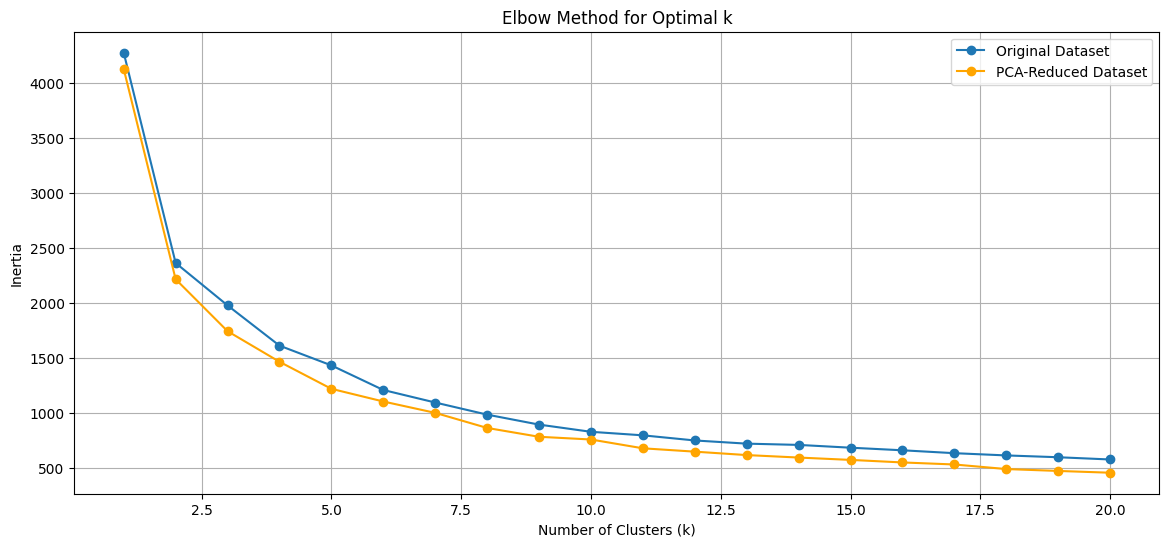

In [33]:
#using Elbow Method to find effecient number of clusters
def optimal_k(data, max_k=20):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    return inertia

numeric_data_preprocessed = data.select_dtypes(include=[np.number])
# numeric_data_reduced = data_pca_reduced.select_dtypes(include=[np.number])

# optimal k for orignal and reduced dataset
k_original = optimal_k(numeric_data_preprocessed, max_k=20)
k_reduced = optimal_k(data_pca, max_k=20)

# Plot Elbow Method
plt.figure(figsize=(14, 6))
plt.plot(range(1, 21), k_original, marker='o', label='Original Dataset')
plt.plot(range(1, 21), k_reduced, marker='o', label='PCA-Reduced Dataset', color='orange')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.grid()
plt.show()

In [34]:
# table of values for k and inertia
k_values = list(range(1, 21))  # Range of k
table_original = pd.DataFrame({'k': k_values, 'Inertia (Original)': k_original})
table_reduced = pd.DataFrame({'k': k_values, 'Inertia (PCA Reduced)': k_reduced})

# comparison
comparison_table = pd.merge(table_original, table_reduced, on='k')

print(comparison_table)


     k  Inertia (Original)  Inertia (PCA Reduced)
0    1         4271.707261            4123.779822
1    2         2360.745515            2213.217338
2    3         1975.162088            1740.775392
3    4         1609.488684            1462.800970
4    5         1429.882788            1216.956694
5    6         1206.281715            1101.699843
6    7         1092.472211             998.518003
7    8          982.433733             861.351651
8    9          891.766134             781.109356
9   10          826.308446             756.309992
10  11          794.199663             676.344136
11  12          747.604495             645.834347
12  13          718.682546             614.785871
13  14          707.209324             592.274290
14  15          681.830125             570.909690
15  16          658.278976             547.804318
16  17          631.998866             529.282867
17  18          611.581372             487.662930
18  19          595.123782             470.607588


In [35]:
# k-means clustering
optimal_k = 4
# k-means
kmeans_ = KMeans(n_clusters=optimal_k, random_state=42)
# KMeans on Original Dataset
kmeans_original = kmeans_.fit_predict(numeric_data_preprocessed)

# KMeans on PCA-Reduced Dataset
kmeans_reduced = kmeans_.fit_predict(data_pca)

# Add cluster labels to datasets for analysis
data_original_clustered = pd.DataFrame(numeric_data_preprocessed, columns=data.columns)
data_original_clustered['Cluster'] = kmeans_original

data_reduced_clustered = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])
data_reduced_clustered['Cluster'] = kmeans_reduced

# Output basic cluster statistics
print("Cluster counts for Original Dataset:")
print(data_original_clustered['Cluster'].value_counts())

print("\nCluster counts for PCA-Reduced Dataset:")
print(data_reduced_clustered['Cluster'].value_counts())


Cluster counts for Original Dataset:
Cluster
3    3789
2    1888
0     948
1     809
Name: count, dtype: int64

Cluster counts for PCA-Reduced Dataset:
Cluster
0    3793
3    1880
2     953
1     808
Name: count, dtype: int64


In [16]:
# metric Dunn index to evaluate the quality of clustering
def dunn_index(data, labels):
    # distance between clusters
    unique_labels = np.unique(labels)
    inter_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            # Extract points belonging to cluster i and j
            points_i = data[labels == unique_labels[i]]
            points_j = data[labels == unique_labels[j]]
            # Calculate minimum distance between points in cluster i and cluster j
            dist = np.min(cdist(points_i, points_j))
            inter_cluster_distances.append(dist)

    # maximum distance within a cluster
    intra_cluster_distances = []
    for label in unique_labels:
        # Extract points belonging to the current cluster
        points = data[labels == label]
        # maximum distance between any two points in the same cluster
        max_dist = np.max(cdist(points, points))
        intra_cluster_distances.append(max_dist)

    # the Dunn Index
    min_inter_cluster_dist = np.min(inter_cluster_distances)
    max_intra_cluster_dist = np.max(intra_cluster_distances)

    return min_inter_cluster_dist / max_intra_cluster_dist


In [36]:
# Calculate Dunn Index for both datasets
dunn_index_data_kmeans = dunn_index(numeric_data_preprocessed, kmeans_original)
dunn_index_data_pca_kmeans = dunn_index(data_pca, kmeans_reduced)

print(f"Dunn Index for Original Dataset: {dunn_index_data_kmeans}")
print(f"Dunn Index for PCA-Reduced Dataset: {dunn_index_data_pca_kmeans}")


Dunn Index for Original Dataset: 0.015347007751643322
Dunn Index for PCA-Reduced Dataset: 0.01437904257552644


In [37]:

# Calculate Silhouette Score for the Original Dataset
silhouette_original_kmeans = silhouette_score(numeric_data_preprocessed, kmeans_original)
print(f"Silhouette Score for Original Dataset: {silhouette_original_kmeans:.4f}")

# Calculate Silhouette Score for the PCA-Reduced Dataset
silhouette_pca_kmeans = silhouette_score(data_pca, kmeans_reduced)
print(f"Silhouette Score for PCA-Reduced Dataset: {silhouette_pca_kmeans:.4f}")


Silhouette Score for Original Dataset: 0.4140
Silhouette Score for PCA-Reduced Dataset: 0.4354


In [69]:
def interpret_clusters(data, cluster_labels, feature_names=None):
    """
    Function to interpret clusters by providing feature-wise mean values for each cluster.
    Returns: Summary of cluster statistics.
    """
    # DataFrame for easier manipulation
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=feature_names or [f"Feature {i+1}" for i in range(data.shape[1])])

    # cluster labels to the dataset
    data['Cluster'] = cluster_labels

    # statistics for each cluster
    cluster_summary = data.groupby('Cluster').mean()

    # the number of points in each cluster
    cluster_summary['Count'] = data['Cluster'].value_counts().sort_index()

    return cluster_summary


In [70]:
#data preprocessed
original_cluster_summary = interpret_clusters(numeric_data_preprocessed, kmeans_original)
print("Cluster Interpretation (Original Dataset):")
print(original_cluster_summary)
#data after pca
pca_cluster_summary = interpret_clusters(data_pca, kmeans_reduced, feature_names=[f"PC{i+1}" for i in range(data_pca.shape[1])])
print("\nCluster Interpretation (PCA-Reduced Dataset):")
print(pca_cluster_summary)


Cluster Interpretation (Original Dataset):
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
0        0.073266           0.973217   0.038934          0.037794   
1        0.005376           0.809991   0.020764          0.008551   
2        0.066057           0.945104   0.021288          0.008726   
3        0.078435           0.858111   0.005349          0.005129   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                      0.016391      0.008462             0.866432   
1                      0.029771      0.000565             0.749976   
2                      0.030615      0.009533             0.877951   
3                      0.002376      0.020981             0.138653   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                         

**Cluster Interpretation**

**1- Data Preprocessed**

**Cluster 0**:
Represents customers with relatively higher purchase frequency and high one-off purchase frequency. Their cash advance usage is low, and they have moderate CREDIT_LIMIT and PAYMENTS. It represents customers with consistent but small-scale spending behavior using credit cards.

**Cluster 1**:
Characterized by moderate credit usage with significantly higher PRC_FULL_PAYMENT, indicating they are likely full payment customers.
Their overall spending (PURCHASES, CASH_ADVANCE) and frequency (PURCHASES_FREQUENCY) are moderate. Represents financially responsible users who avoid carrying balances.

**Cluster 2**:
Shows high purchase frequency but a low proportion of full payments. They also have relatively high installment purchases and slightly higher cash advances compared to other clusters. Likely represents customers with frequent but small purchases and some dependence on installment payments or cash advances.

**Cluster 3**:
Represents customers with minimal spending activity and low one-off purchases.
Their CASH_ADVANCE_FREQUENCY is the highest (~0.10), suggesting cash advance reliance. Likely represents customers with low card usage and possibly financial stress leading to cash advance usage.

**2- Data After PCA**

**Cluster 0**:
Negative PC1 (-0.487575) suggests conservative spending behavior with limited credit card reliance. Largest group with 3793 members, indicating a common cluster with low variability in spending.

**Cluster 1**:
Positive PC1 (0.506324) and PC3 (0.558404) suggest higher overall spending and payments, with variance in payment behavior as indicated by PC4 (0.128860).
A smaller cluster (808 members), likely representing high-spending and responsible users.

**Cluster 2**:
Strong positive PC2 (0.608166) indicates a distinct group with variability in purchase frequency or cash advances. Comprises 953 members, possibly representing customers with erratic but significant credit behavior.

**Cluster 3**:
Dominant positive PC1 (0.555465) with negative PC3 (-0.209507), indicating moderate spending but low installment or one-off purchases. Second largest group with 1880 members, potentially representing typical credit card users with stable spending patterns.

# **Hierarchical Clustering**

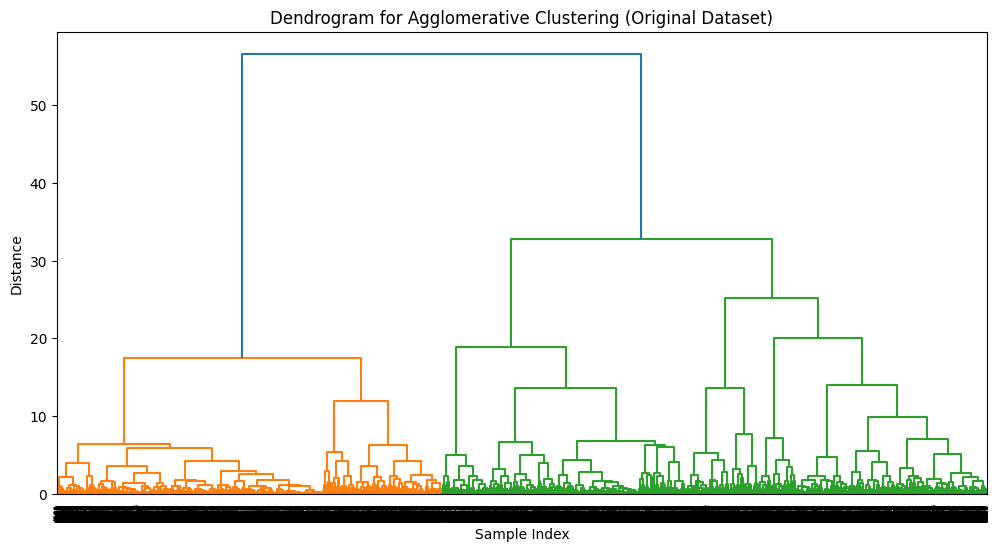

In [38]:

# linkage matrix of data after preprocessing for hierarchical clustering
linkage_matrix_data_preprocessed = linkage(numeric_data_preprocessed, method='ward')

# Create a dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_data_preprocessed)
plt.title("Dendrogram for Agglomerative Clustering (Original Dataset)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


Cluster distribution in Original Dataset:
Cluster_Original
6    2130
1    1585
0    1525
2     954
3     576
5     368
4     296
Name: count, dtype: int64


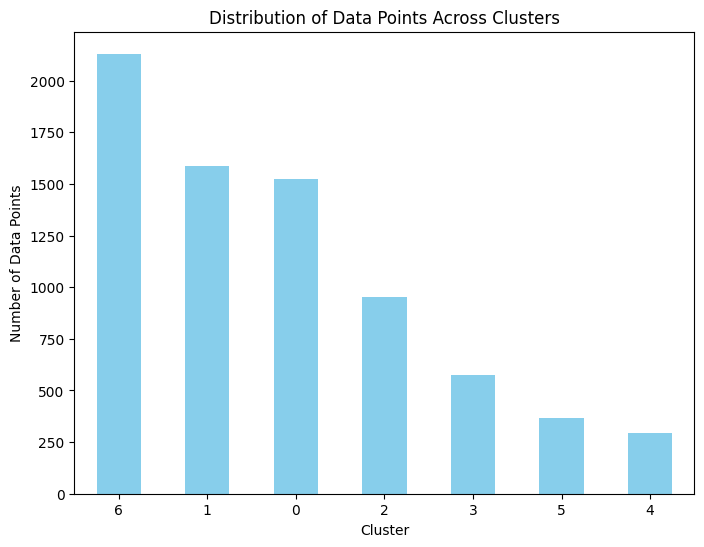

In [39]:
# choosing 7 clusters based on the dendrogram
n_clusters = 7

# agglomerative clustering with the chosen number of clusters
agg_clust = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

data_preprocessed_Hierarchical = numeric_data_preprocessed
labels_data_Hierarchical = agg_clust.fit_predict(data_preprocessed_Hierarchical)

# adding cluster labels to the preprocessed data
data_preprocessed_Hierarchical['Cluster_Original'] = labels_data_Hierarchical

# the distribution of data points across the clusters
cluster_counts = data_preprocessed_Hierarchical['Cluster_Original'].value_counts()
print("Cluster distribution in Original Dataset:")
print(cluster_counts)

# rows of the updated dataset
#print("\nFirst few rows of the dataset with cluster labels:")
#print(data_preprocessed_Hierarchical.head())

# plotting the distribution of clusters
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Data Points Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=0)
plt.show()

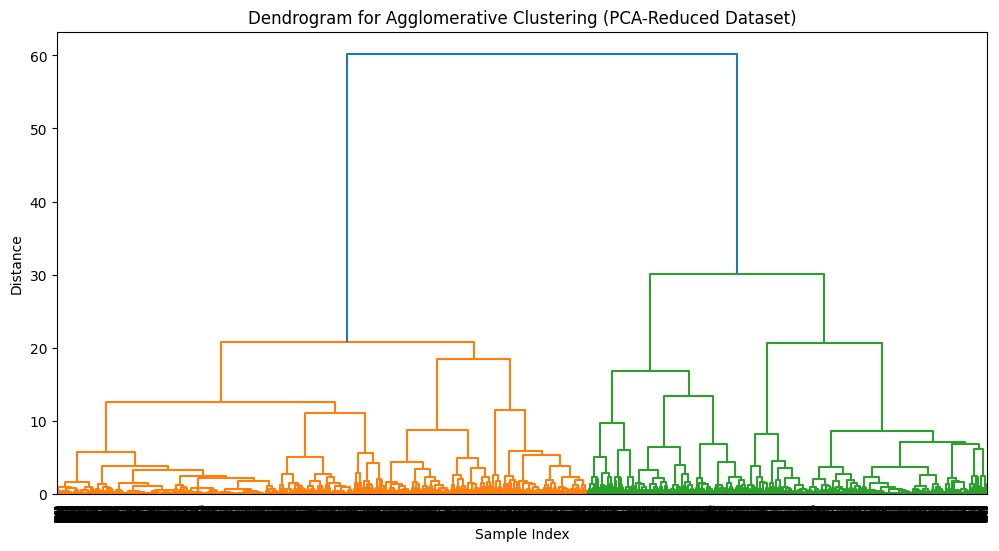

In [40]:
# agglomerative clustering on the PCA-reduced data
linkage_matrix_data_pca = linkage(data_pca, method='ward')

# Create a dendrogram for PCA-reduced data
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix_data_pca)
plt.title("Dendrogram for Agglomerative Clustering (PCA-Reduced Dataset)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


Cluster distribution in PCA-Reduced Dataset:
Cluster_PCA
1    2619
3    1429
0     895
5     860
2     764
4     486
6     381
Name: count, dtype: int64


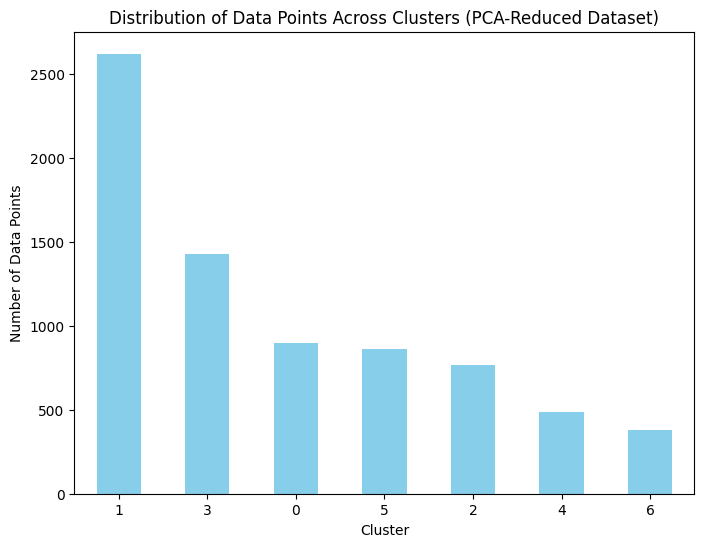

In [41]:
# choosing 6 clusters based on the dendrogram
n_clusters_pca = 7

# agglomerative clustering with the chosen number of clusters
agg_clust_pca = AgglomerativeClustering(n_clusters=n_clusters_pca, linkage='ward')
labels_data_pca_Hierarchical = agg_clust_pca.fit_predict(data_pca)

# adding cluster labels to the PCA-reduced data
data_pca_Hierarchical = pd.DataFrame(data_pca, columns=[f"PC{i+1}" for i in range(data_pca.shape[1])])
data_pca_Hierarchical['Cluster_PCA'] = labels_data_pca_Hierarchical

# the distribution of data points across the clusters
cluster_counts_pca = data_pca_Hierarchical['Cluster_PCA'].value_counts()
print("Cluster distribution in PCA-Reduced Dataset:")
print(cluster_counts_pca)

# Display the first few rows of the updated dataset
#print("\nFirst few rows of the dataset with cluster labels:")
#print(data_pca_Hierarchical.head())

# Optionally, you can visualize the distribution of clusters using a bar plot
plt.figure(figsize=(8, 6))
cluster_counts_pca.plot(kind='bar', color='skyblue')
plt.title('Distribution of Data Points Across Clusters (PCA-Reduced Dataset)')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=0)
plt.show()


In [42]:
dunn_data_Hierarchical = dunn_index(numeric_data_preprocessed, labels_data_Hierarchical)
print(f"Dunn Index for Original Dataset: {dunn_data_Hierarchical}")

# Calculate Dunn Index for the PCA-Reduced Dataset
dunn_pca_Hierarchical = dunn_index(data_pca, labels_data_pca_Hierarchical)
print(f"Dunn Index for PCA-Reduced Dataset: {dunn_pca_Hierarchical}")



Dunn Index for Original Dataset: 0.5631876445245434
Dunn Index for PCA-Reduced Dataset: 0.015193346660214043


In [43]:
# Calculate Silhouette Score for the Original Dataset
silhouette_data_Hierarchical = silhouette_score(numeric_data_preprocessed, labels_data_Hierarchical)
print(f"Silhouette Score for Original Dataset: {silhouette_data_Hierarchical:.4f}")

# Calculate Silhouette Score for the PCA-Reduced Dataset
silhouette_pca_Hierarchical = silhouette_score(data_pca, labels_data_pca_Hierarchical)
print(f"Silhouette Score for PCA-Reduced Dataset: {silhouette_pca_Hierarchical:.4f}")


Silhouette Score for Original Dataset: 0.6578
Silhouette Score for PCA-Reduced Dataset: 0.3178


In [71]:
#data preprocessed
original_cluster_summary = interpret_clusters(numeric_data_preprocessed, labels_data_Hierarchical)
print("Cluster Interpretation (Original Dataset):")
print(original_cluster_summary)
#data after pca
pca_cluster_summary = interpret_clusters(data_pca, labels_data_pca_Hierarchical, feature_names=[f"PC{i+1}" for i in range(data_pca.shape[1])])
print("\nCluster Interpretation (PCA-Reduced Dataset):")
print(pca_cluster_summary)


Cluster Interpretation (Original Dataset):
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
0        0.064299           0.921437   0.016720          0.012282   
1        0.067928           0.955718   0.027691          0.014255   
2        0.029474           0.554694   0.007032          0.007108   
3        0.052250           0.972448   0.039174          0.039187   
4        0.003792           0.479904   0.010040          0.006026   
5        0.005034           0.972631   0.019692          0.002589   
6        0.107419           0.987951   0.002482          0.002461   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                      0.014222      0.009053             0.548987   
1                      0.034544      0.008802             0.957875   
2                      0.002467      0.018255          

**Cluster Interpretation for Hierarchical Clustering**

**Dataset Preprocessed**

**Cluster 0:**
Moderate card usage, characterized by mid-range BALANCE_FREQUENCY (~0.92) and purchase frequency (~0.55). Low ONEOFF_PURCHASES_FREQUENCY and minimal reliance on installment purchases. Represents moderate spenders who use their cards occasionally but not heavily.

**Cluster 1:**
High BALANCE_FREQUENCY (~0.96), frequent purchases (PURCHASES_FREQUENCY ≈ 0.96), and reliance on installment purchases (PURCHASES_INSTALLMENTS_FREQUENCY ≈ 0.91). Low cash advance usage, indicating steady card usage for purchases.
Represents consistent and frequent card users.

**Cluster 2:**
Low card activity across all metrics, including PURCHASES_FREQUENCY (~0.16) and high reliance on cash advances (CASH_ADVANCE_FREQUENCY ≈ 0.07). Low purchase transactions, indicating minimal card usage. Likely represents infrequent users or financially constrained customers.

**Cluster 3:**
High BALANCE_FREQUENCY (~0.97), significant one-off purchases (ONEOFF_PURCHASES_FREQUENCY ≈ 0.89), and frequent card usage (PURCHASES_FREQUENCY ≈ 0.93). Low installment purchases suggest preference for one-off transactions. Represents high-value, occasional spenders.

**Cluster 4:**
High PRC_FULL_PAYMENT (~0.83) with moderate purchase activity
(PURCHASES_FREQUENCY ≈ 0.32). Represents low-frequency, financially responsible users who pay balances in full regularly.

**Cluster 5:**
High reliance on installment purchases (PURCHASES_INSTALLMENTS_FREQUENCY ≈ 0.92) but minimal one-off purchases. Low cash advances and high PRC_FULL_PAYMENT (~0.82). Represents systematic and disciplined installment users.

**Cluster 6:**
Low spending activity across all metrics, with the highest reliance on cash advances (CASH_ADVANCE_FREQUENCY ≈ 0.14). Likely represents financially stressed or occasional users.

**PCA-Reduced Data**

**Cluster 0:**
Positive PC1 (0.459218) and PC2 (0.475225) suggest balanced card usage with steady but not extreme variability. Represents typical users with average behavior.

**Cluster 1:**
Strong negative PC1 (-0.536413) with balanced variability in other components.
Largest cluster (~2619 members), likely representing conservative users or low spenders.

**Cluster 2:**
Negative PC1 (-0.486185) and moderately high PC3 (0.312417) suggest some variability in spending and cash advance behavior.Represents a smaller segment of variable spenders.

**Cluster 3:**
Strong positive PC1 (0.600527) with slight negative PC2 (-0.257430), indicating frequent usage with moderate diversity in transaction types.Likely represents frequent, high-spending customers.

**Cluster 4:**
Positive PC1 (0.664093) and high PC3 (0.519102), representing a unique group of highly variable and possibly high-value customers.Smallest cluster (~486 members), likely high-value targets.

**Cluster 5:**
Balanced metrics with no extreme variabilities, suggesting general-purpose users. Represents a small segment of stable users.

**Cluster 6:**
Strong positive values for PC1 (0.581767), PC2 (0.528110), and PC3 (0.502245), indicating diverse spending patterns with frequent and varied usage. Likely represents diverse high-usage customers.


# **Spectral Clustering**

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Cluster distribution in Original Dataset (Spectral Clustering):
Cluster_Original_Spectral
0    4767
2    2457
3     169
1      41
Name: count, dtype: int64

Cluster distribution in PCA-Reduced Dataset (Spectral Clustering):
Cluster_PCA_Spectral
0    3903
2    2718
1     670
3     143
Name: count, dtype: int64


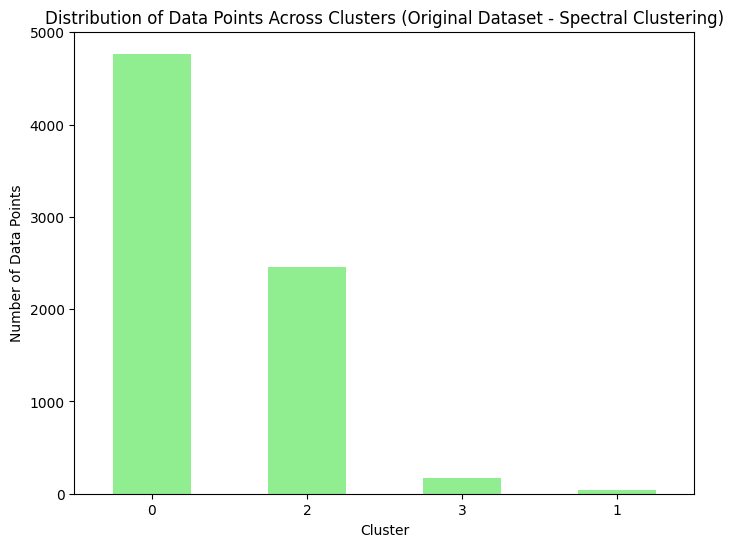

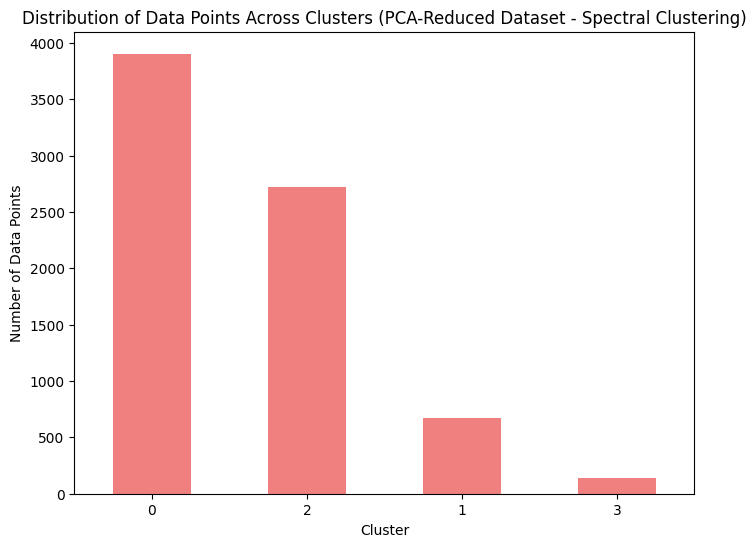

In [62]:
# spectral clustering for data after preprocessing
n_clusters_spectral = 4
spectral_clust = SpectralClustering(n_clusters=n_clusters_spectral, affinity='nearest_neighbors', random_state=42)

data_preprocessed_spectral = numeric_data_preprocessed

labels_data_spectral = spectral_clust.fit_predict(data_preprocessed_spectral)

# cluster labels to the preprocessed data
data_preprocessed_spectral['Cluster_Original_Spectral'] = labels_data_spectral

# spectral clustering for the PCA-Reduced data
labels_pca_spectral = spectral_clust.fit_predict(data_pca)

# cluster labels to the PCA-reduced data
data_preprocessed_spectral['Cluster_PCA_Spectral'] = labels_pca_spectral

# the distribution of data points across the clusters for the preprocessed data
cluster_counts_original_Spectral = data_preprocessed_spectral['Cluster_Original_Spectral'].value_counts()
print("Cluster distribution in Original Dataset (Spectral Clustering):")
print(cluster_counts_original_Spectral)

# the distribution of data points across the clusters for the PCA-reduced data
cluster_counts_pca_Spectral = data_preprocessed_spectral['Cluster_PCA_Spectral'].value_counts()
print("\nCluster distribution in PCA-Reduced Dataset (Spectral Clustering):")
print(cluster_counts_pca_Spectral)

# plotting
plt.figure(figsize=(8, 6))
cluster_counts_original_Spectral.plot(kind='bar', color='lightgreen')
plt.title('Distribution of Data Points Across Clusters (Original Dataset - Spectral Clustering)')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=0)
plt.show()


plt.figure(figsize=(8, 6))
cluster_counts_pca_Spectral.plot(kind='bar', color='lightcoral')
plt.title('Distribution of Data Points Across Clusters (PCA-Reduced Dataset - Spectral Clustering)')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=0)
plt.show()


In [63]:
# Calculate Dunn Index for the Original Dataset
dunn_original_spectral = dunn_index(data_preprocessed_spectral, labels_data_spectral)
print(f"Dunn Index for Original Dataset (Spectral Clustering): {dunn_original_spectral}")

# Calculate Dunn Index for the PCA-Reduced Dataset
dunn_pca_spectral = dunn_index(data_pca, labels_pca_spectral)
print(f"Dunn Index for PCA-Reduced Dataset (Spectral Clustering): {dunn_pca_spectral}")

Dunn Index for Original Dataset (Spectral Clustering): 0.145801106227816
Dunn Index for PCA-Reduced Dataset (Spectral Clustering): 0.0005597854718482195


In [65]:
# Calculate Silhouette Score for the Original Dataset
silhouette_data_spectral = silhouette_score(data_preprocessed_spectral, labels_data_spectral)
print(f"Silhouette Score for Original Dataset: {silhouette_data_spectral:.4f}")

# Calculate Silhouette Score for the PCA-Reduced Dataset
silhouette_pca_spectral = silhouette_score(data_pca, labels_pca_spectral)
print(f"Silhouette Score for PCA-Reduced Dataset: {silhouette_pca_spectral:.4f}")


Silhouette Score for Original Dataset: 0.0180
Silhouette Score for PCA-Reduced Dataset: 0.0584


In [72]:
#data preprocessed
original_cluster_summary = interpret_clusters(numeric_data_preprocessed, labels_data_spectral)
print("Cluster Interpretation (Original Dataset):")
print(original_cluster_summary)
#data after pca
pca_cluster_summary = interpret_clusters(data_pca, labels_pca_spectral, feature_names=[f"PC{i+1}" for i in range(data_pca.shape[1])])
print("\nCluster Interpretation (PCA-Reduced Dataset):")
print(pca_cluster_summary)


Cluster Interpretation (Original Dataset):
          BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
0        0.071369           0.878253   0.009385          0.006651   
1        0.068176           1.000000   0.000000          0.000000   
2        0.056526           0.902318   0.028257          0.019109   
3        0.081768           1.000000   0.000000          0.000000   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                      0.008420      0.017426             0.307050   
1                      0.000000      0.012777             0.000000   
2                      0.026978      0.007759             0.873962   
3                      0.000000      0.019620             0.000000   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                         

**Cluster Interpretation for Spectral Clustering**

**Data Preprocessed**

**Cluster 0:**
Moderate BALANCE (0.071), BALANCE_FREQUENCY (~0.88), and low PURCHASES (~0.009).
Low ONEOFF_PURCHASES and moderate cash advance frequency (~0.08). Represents moderate users with infrequent purchases and occasional reliance on cash advances.

**Cluster 1:**
High BALANCE_FREQUENCY (1.0) but no purchases (PURCHASES = 0, ONEOFF_PURCHASES = 0). Low credit limit and payments, with slightly higher CASH_ADVANCE_FREQUENCY (~0.16). Likely represents inactive or dormant users relying primarily on cash advances.

**Cluster 2:**
Moderate BALANCE (~0.056), high BALANCE_FREQUENCY (~0.90), and significant PURCHASES_FREQUENCY (~0.87). Reliance on both installment and one-off purchases, with low CASH_ADVANCE_FREQUENCY (~0.04). Represents active and frequent card users using the card for diverse spending needs.

**Cluster 3:**
High BALANCE_FREQUENCY (1.0) with no purchases or installments, and the highest CASH_ADVANCE_FREQUENCY (~0.21). Minimal payments and credit limits, indicating financially constrained or cash-dependent users.

**PCA-Reduced Data**

**Cluster 0:**
Positive PC1 (0.469) with minimal variability in other components.
Represents the majority of users with balanced card usage.

**Cluster 1:**
Strong negative PC1 (-0.639) and high variability in higher-order components.
Represents a smaller group of dormant or specialized users.

**Cluster 2:**
Negative PC1 (-0.483) with balanced variability across components.
Represents frequent, active users who form the second-largest cluster.

**Cluster 3:**
Strong negative PC1 (-0.631) with significant variability in PC4 and PC5.
Represents financially constrained or cash-dependent users similar to the original dataset analysis.


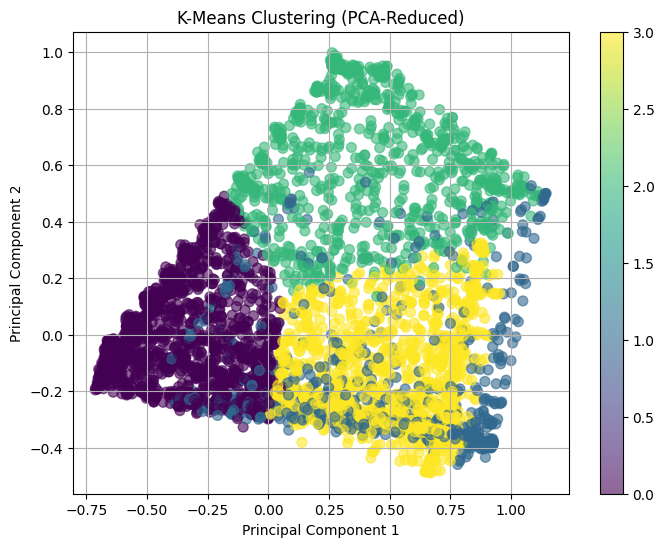

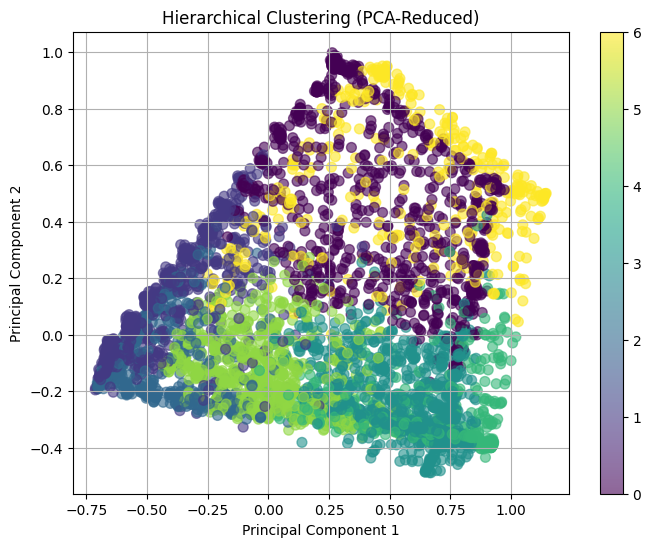

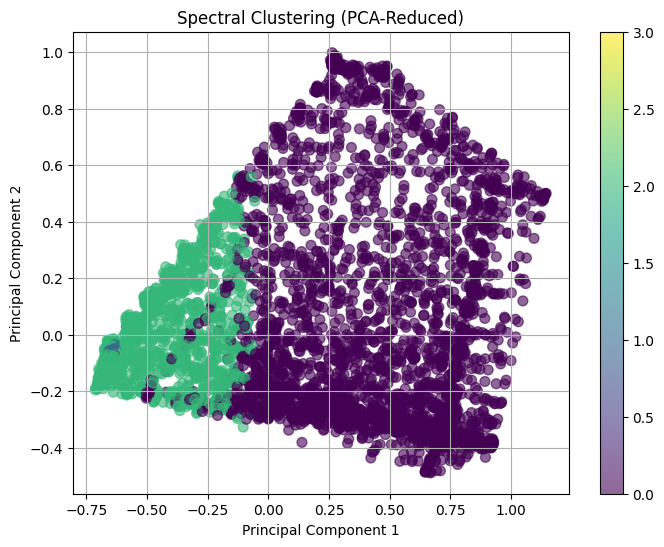

In [66]:
# Visualization of Clusters (2D PCA)
def plot_clusters_2d(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

# Visualizations
plot_clusters_2d(data_pca, kmeans_reduced, "K-Means Clustering (PCA-Reduced)")
plot_clusters_2d(data_pca, labels_data_pca_Hierarchical, "Hierarchical Clustering (PCA-Reduced)")
plot_clusters_2d(data_pca, labels_pca_spectral, "Spectral Clustering (PCA-Reduced)")


# **Analysis and Justification**

**Chosen Model: Hierarchical Clustering on the Original Dataset**

The dataset after preprocessing achieves the highest Dunn Index (0.5632) and Silhouette Score (0.6578) compared to all other models and preprocessing methods. This indicates well-separated and cohesive clusters.

PCA preprocessing significantly deteriorates both metrics for Hierarchical Clustering, suggesting that the original high-dimensional data preserves essential relationships between features.

Hierarchical clustering on the original dataset provides the most reliable and interpretable clusters.
PCA preprocessing is more beneficial for K-Means, slightly improving cluster definition.
Spectral Clustering, while capable of handling non-linear relationships, performs poorly on both datasets, likely due to the datasets structure and the clustering algorithm's sensitivity to parameter tuning.